# Non-trivial models analysis - debugging

Created 28/04/2025

Objectives:
* Debug optimisation scheme, something wrong.

# Package imports

In [1]:
import sys
sys.path.append('../../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [129]:
from scipy.linalg import expm as matrix_exponential

In [253]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors,
    get_npc_identity_operator,
    get_left_side_right_symmetry_environment
)

from SPTOptimization.tenpy_leg_label_utils import (
    swap_left_right_indices
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

# Load data

In [5]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [6]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [7]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [8]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [9]:
MAX_VIRTUAL_BOND_DIM = 8
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [10]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [11]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [12]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [13]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [14]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [15]:
fermionic_np_symmetries = [np_I, np_JW]

In [16]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [17]:
npc_JW = fermionic_npc_symmetries[1]

In [18]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [19]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [20]:
cases_triv_proj_rep = dict()

for k, psi in loaded_data_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_triv_proj_rep[(k, i, j)] = case

In [21]:
for c in cases_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [22]:
cases_non_triv_proj_rep = dict()

for k, psi in loaded_data_non_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_non_triv_proj_rep[(k, i, j)] = case

In [23]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [24]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [25]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

# Debug

## Test case

In [26]:
block_width = 3
num_one_sided_iterations = 1
num_two_sided_iterations = 30
num_layers = 1
num_sites = 3

In [27]:
debug_opt = MPSBrickSolver(
    cases_non_triv_proj_rep[(0.55, 1, 1)],
    num_sites,
    block_width,
    num_layers,
    num_one_sided_iterations,
    num_two_sided_iterations,
    max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
)

In [28]:
debug_opt.optimise()

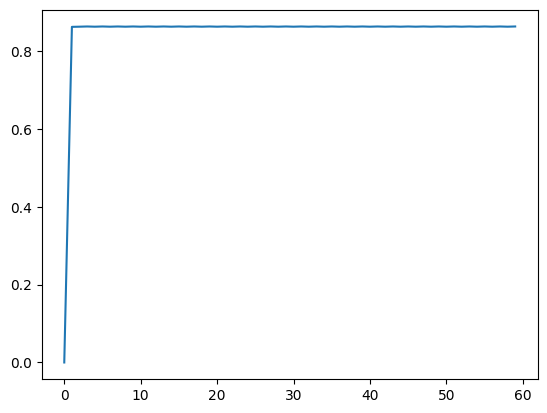

In [29]:
plt.plot(debug_opt.flatten_exps())

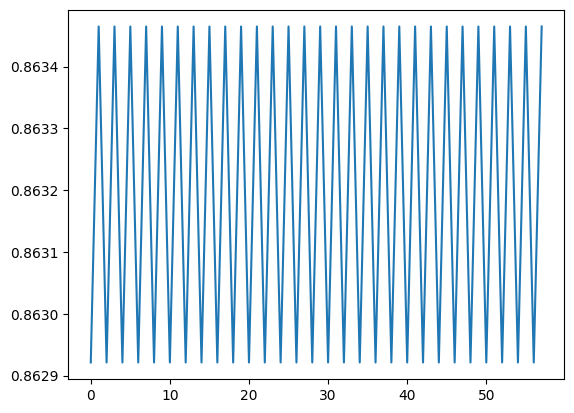

In [30]:
plt.plot(debug_opt.flatten_exps()[2:])

Flip flopping.

Code up manually, see what happens.

In [31]:
debug_case = cases_non_triv_proj_rep[(0.55, 1, 1)]

In [32]:
transfer_matrix = debug_case.npc_symmetry_transfer_matrix

In [33]:
debug_case.right_symmetry_index

139

In [34]:
list(range(10, 7, -1))

[10, 9, 8]

In [35]:
t = transfer_matrix

right_bs = [
    debug_case.psi.get_B(i)
    for i in range(debug_case.right_symmetry_index+1, debug_case.right_symmetry_index+4)
]

for i, b in enumerate(right_bs):
    t = npc.tensordot(t, b, [['vR',], ['vL']]).replace_label('p', f'p{i}')
    t = npc.tensordot(t, b.conj(), [['vR*',], ['vL*']]).replace_label('p*', f'p{i}*')

t = npc.trace(t, 'vR', 'vR*')

t = (
    t
    .combine_legs([['p0', 'p1', 'p2'], ['p0*', 'p1*', 'p2*']])
    .replace_label('(p0.p1.p2)', 'rp')
    .replace_label('(p0*.p1*.p2*)', 'rp*')
)

left_bs = [
    debug_case.psi.get_B(i, form='A')
    for i in range(debug_case.left_symmetry_index-1, debug_case.left_symmetry_index-4, -1)
]

for i, b in enumerate(left_bs):
    t = npc.tensordot(t, b, [['vL',], ['vR']]).replace_label('p', f'p{i}')
    t = npc.tensordot(t, b.conj(), [['vL*',], ['vR*']]).replace_label('p*', f'p{i}*')

t = npc.trace(t, 'vL', 'vL*')

t = (
    t
    .combine_legs([['p0', 'p1', 'p2'], ['p0*', 'p1*', 'p2*']])
    .replace_label('(p0.p1.p2)', 'lp')
    .replace_label('(p0*.p1*.p2*)', 'lp*')
)

In [36]:
left_right_rdm = t

In [37]:
left_right_rdm

<npc.Array shape=(32, 32, 16, 16) labels=['rp', 'rp*', 'lp', 'lp*']>

In [38]:
def get_npc_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [39]:
left_unitary = npc.diag(
    1,
    leg=left_right_rdm.get_leg('lp'),
    dtype='complex',
    labels=['lp', 'lp*']
)

In [40]:
right_unitary = npc.diag(
    1,
    leg=left_right_rdm.get_leg('rp'),
    dtype='complex',
    labels=['rp', 'rp*']
)

In [187]:
def iteration_step(rdm, left_unitary, right_unitary):
    left_rdm = npc.tensordot(rdm, right_unitary, [['rp', 'rp*'], ['rp*', 'rp']])

    U, S, VH = npc.svd(
        left_rdm.conj(),
        compute_uv=True,
        inner_labels=['i', 'i*']
    )

    out_left_unitary = npc.tensordot(U, VH, [['i',], ['i*',]])
    left_exp = np.sum(S)

    right_rdm = npc.tensordot(rdm, out_left_unitary, [['lp', 'lp*'], ['lp*', 'lp']])

    U, S, VH = npc.svd(
        right_rdm.conj(),
        compute_uv=True,
        inner_labels=['i', 'i*']
    )

    out_right_unitary = npc.tensordot(U, VH, [['i',], ['i*',]])
    right_exp = np.sum(S)

    return (right_exp, left_exp), out_right_unitary, out_left_unitary

In [42]:
exps = list()

for _ in range(10):
    out = iteration_step(left_right_rdm, left_unitary, right_unitary)

    exps.extend(out[0])

    right_unitary, left_unitary = out[1:]

In [43]:
exps

[4.768210584463934e-17,
 0.7857672824010177,
 0.8607407754736202,
 0.8607407754736199,
 0.8607407754736198,
 0.8607407754736199,
 0.8607407754736192,
 0.8607407754736199,
 0.8607407754736195,
 0.8607407754736196,
 0.86074077547362,
 0.8607407754736195,
 0.8607407754736196,
 0.8607407754736199,
 0.8607407754736196,
 0.8607407754736197,
 0.8607407754736197,
 0.8607407754736195,
 0.8607407754736198,
 0.8607407754736198]

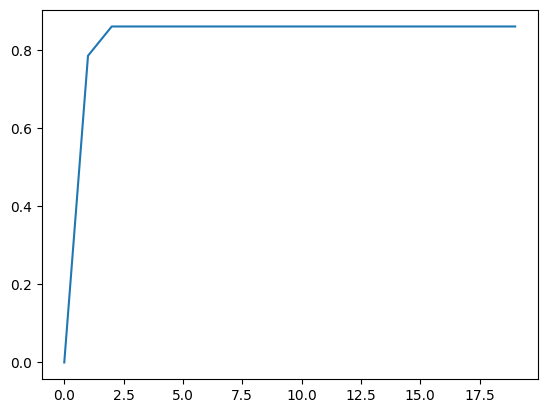

In [44]:
plt.plot(exps)

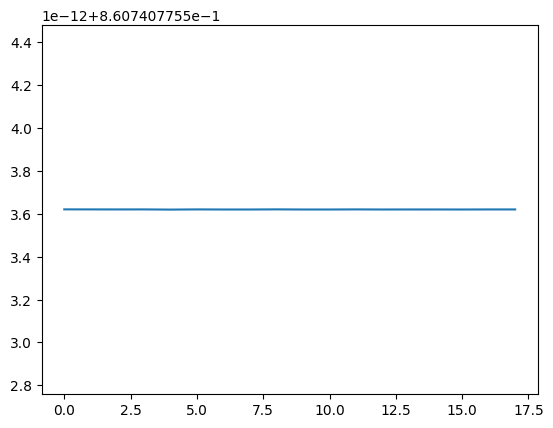

In [45]:
plt.plot(exps[2:])

That looks much better!

## Step through and compare

In [46]:
block_width = 3
num_one_sided_iterations = 1
num_two_sided_iterations = 30
num_layers = 1
num_sites = 3

In [47]:
debug_opt = MPSBrickSolver(
    cases_non_triv_proj_rep[(0.55, 1, 1)],
    num_sites,
    block_width,
    num_layers,
    num_one_sided_iterations,
    num_two_sided_iterations,
    max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
)

In [48]:
debug_opt.add_new_layer()

In [49]:
debug_opt.optimise_left_layer()

In [62]:
debug_opt.flatten_exps()

[]

In [63]:
debug_opt.left_expectations

[[[[2.286419450530964e-17]]]]

In [50]:
debug_case = cases_non_triv_proj_rep[(0.55, 1, 1)]

In [51]:
transfer_matrix = debug_case.npc_symmetry_transfer_matrix

In [54]:
t = transfer_matrix

right_bs = [
    debug_case.psi.get_B(i)
    for i in range(debug_case.right_symmetry_index+1, debug_case.right_symmetry_index+4)
]

for i, b in enumerate(right_bs):
    t = npc.tensordot(t, b, [['vR',], ['vL']]).replace_label('p', f'p{i}')
    t = npc.tensordot(t, b.conj(), [['vR*',], ['vL*']]).replace_label('p*', f'p{i}*')

t = npc.trace(t, 'vR', 'vR*')

t = (
    t
    .combine_legs([['p0', 'p1', 'p2'], ['p0*', 'p1*', 'p2*']])
    .replace_label('(p0.p1.p2)', 'rp')
    .replace_label('(p0*.p1*.p2*)', 'rp*')
)

left_bs = [
    debug_case.psi.get_B(i, form='A')
    for i in range(debug_case.left_symmetry_index-1, debug_case.left_symmetry_index-4, -1)
]

for i, b in enumerate(left_bs):
    t = npc.tensordot(t, b, [['vL',], ['vR']]).replace_label('p', f'p{i}')
    t = npc.tensordot(t, b.conj(), [['vL*',], ['vR*']]).replace_label('p*', f'p{i}*')

t = npc.trace(t, 'vL', 'vL*')

t = (
    t
    .combine_legs([['p0', 'p1', 'p2'], ['p0*', 'p1*', 'p2*']])
    .replace_label('(p0.p1.p2)', 'lp')
    .replace_label('(p0*.p1*.p2*)', 'lp*')
)

In [55]:
left_right_rdm = t

In [56]:
left_right_rdm

<npc.Array shape=(32, 32, 16, 16) labels=['rp', 'rp*', 'lp', 'lp*']>

In [57]:
left_unitary = npc.diag(
    1,
    leg=left_right_rdm.get_leg('lp'),
    dtype='complex',
    labels=['lp', 'lp*']
)

In [58]:
right_unitary = npc.diag(
    1,
    leg=left_right_rdm.get_leg('rp'),
    dtype='complex',
    labels=['rp', 'rp*']
)

In [59]:
def left_iteration_step(rdm, right_unitary):
    left_rdm = npc.tensordot(rdm, right_unitary, [['rp', 'rp*'], ['rp*', 'rp']])

    U, S, VH = npc.svd(
        left_rdm.conj(),
        compute_uv=True,
        inner_labels=['i', 'i*']
    )

    out_left_unitary = npc.tensordot(U, VH, [['i',], ['i*',]])
    left_exp = np.sum(S)

    return out_left_unitary, left_exp

In [66]:
def right_iteration_step(rdm, left_unitary):
    right_rdm = npc.tensordot(rdm, left_unitary, [['lp', 'lp*'], ['lp*', 'lp']])

    U, S, VH = npc.svd(
        right_rdm.conj(),
        compute_uv=True,
        inner_labels=['i', 'i*']
    )

    out_right_unitary = npc.tensordot(U, VH, [['i',], ['i*',]])
    right_exp = np.sum(S)

    return out_right_unitary, right_exp

In [67]:
current_left_unitary, current_left_exp = left_iteration_step(t, right_unitary)

In [68]:
current_left_exp

1.5203088597106105e-17

In [64]:
debug_opt.optimise_right_layer()

In [65]:
debug_opt.right_expectations

[[[[0.8625002455430719]]]]

In [71]:
current_right_unitary, current_right_exp = right_iteration_step(t, current_left_unitary)

In [77]:
current_right_exp

0.8518627216071814

Close... but not the same.

In [72]:
debug_opt.optimise_left_layer()

In [73]:
debug_opt.flatten_exps()

[2.286419450530964e-17, 0.8625002455430719]

In [74]:
debug_opt.left_expectations

[[[[2.286419450530964e-17]], [[0.8629213427020077]]]]

In [75]:
current_left_unitary, current_left_exp = left_iteration_step(t, current_right_unitary)

In [76]:
current_left_exp

0.8607407754736193

In [78]:
debug_opt.optimise_right_layer()

In [79]:
debug_opt.right_expectations

[[[[0.8625002455430719]], [[0.8634647572157061]]]]

In [80]:
current_right_unitary, current_right_exp = right_iteration_step(t, current_left_unitary)

In [81]:
current_right_exp

0.8607407754736196

Marginal improvement...

In [82]:
debug_opt.optimise_left_layer()

In [83]:
debug_opt.flatten_exps()

[2.286419450530964e-17,
 0.8625002455430719,
 0.8629213427020077,
 0.8634647572157061]

In [84]:
debug_opt.left_expectations

[[[[2.286419450530964e-17]], [[0.8629213427020077]], [[0.8629213427011407]]]]

And there is the problem.

In [85]:
current_left_unitary, current_left_exp = left_iteration_step(t, current_right_unitary)

In [86]:
current_left_exp

0.8607407754736199

Plug in "true" solutions and see what happens.

In [92]:
block_width = 3
num_one_sided_iterations = 1
num_two_sided_iterations = 30
num_layers = 1
num_sites = 3

In [98]:
debug_opt = MPSBrickSolver(
    cases_non_triv_proj_rep[(0.55, 1, 1)],
    num_sites,
    block_width,
    num_layers,
    num_one_sided_iterations,
    num_two_sided_iterations,
    max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
)

In [99]:
debug_opt.add_new_layer()

In [103]:
debug_opt.right_current_layer_unitaries = [
    current_right_unitary.replace_labels(['rp', 'rp*'], ['(p0.p1.p2)', '(p0*.p1*.p2*)']),
]
debug_opt.left_current_layer_unitaries = [
    current_left_unitary.replace_labels(['lp', 'lp*'], ['(p0.p1.p2)', '(p0*.p1*.p2*)']),
]

In [104]:
debug_opt.optimise_left_layer()

In [105]:
debug_opt.left_expectations

[[[[2.286419450530964e-17]]]]

In [106]:
debug_opt.right_expectations

[[]]

In [107]:
debug_opt.optimise_right_layer()

In [108]:
debug_opt.right_expectations

[[[[0.8625002455430719]]]]

In [118]:
block_width = 3
num_one_sided_iterations = 1
num_two_sided_iterations = 30
num_layers = 1
num_sites = 3

In [119]:
debug_opt = MPSBrickSolver(
    cases_non_triv_proj_rep[(0.55, 1, 1)],
    num_sites,
    block_width,
    num_layers,
    num_one_sided_iterations,
    num_two_sided_iterations,
    max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
)

In [120]:
debug_opt.add_new_layer()

In [121]:
debug_opt.left_unitaries

[]

In [122]:
debug_opt.right_current_layer_unitaries = [
    current_right_unitary.replace_labels(['rp', 'rp*'], ['(p0.p1.p2)', '(p0*.p1*.p2*)']),
]
debug_opt.left_current_layer_unitaries = [
    current_left_unitary.replace_labels(['lp', 'lp*'], ['(p0.p1.p2)', '(p0*.p1*.p2*)']),
]

In [125]:
debug_opt.left_unitaries.append(debug_opt.left_current_layer_unitaries)
debug_opt.right_unitaries.append(debug_opt.right_current_layer_unitaries)

In [124]:
debug_opt.left_current_layer_unitaries

[<npc.Array shape=(16, 16) labels=['(p0*.p1*.p2*)', '(p0.p1.p2)']>]

In [126]:
debug_opt.left_unitaries

[[<npc.Array shape=(16, 16) labels=['(p0*.p1*.p2*)', '(p0.p1.p2)']>]]

In [127]:
debug_opt.right_unitaries

[[<npc.Array shape=(32, 32) labels=['(p0*.p1*.p2*)', '(p0.p1.p2)']>]]

In [128]:
debug_opt.manual_expectation_value()

(0.8656522252710772+0j)

In [104]:
debug_opt.optimise_left_layer()

In [105]:
debug_opt.left_expectations

[[[[2.286419450530964e-17]]]]

In [106]:
debug_opt.right_expectations

[[]]

In [107]:
debug_opt.optimise_right_layer()

In [108]:
debug_opt.right_expectations

[[[[0.8625002455430719]]]]

## Generate solution and perturb

In [130]:
current_right_unitary

<npc.Array shape=(32, 32) labels=['rp*', 'rp']>

In [131]:
current_left_unitary

<npc.Array shape=(16, 16) labels=['lp*', 'lp']>

In [164]:
hermitian = np.zeros((16, 16))

for i in range(15):
    hermitian[i, i+1] = 1
    hermitian[i+1, i] = 1

unitary1 = matrix_exponential(1j*0.4*hermitian)

npc_unitary_l = npc.Array.from_ndarray_trivial(unitary1, labels=['lp', 'lp*'])

In [165]:
np.all(hermitian == hermitian.T)

True

In [166]:
hermitian = np.zeros((32, 32))

for i in range(31):
    hermitian[i, i+1] = 1
    hermitian[i+1, i] = 1

unitary2 = matrix_exponential(1j*0.4*hermitian)

npc_unitary_r = npc.Array.from_ndarray_trivial(unitary2, labels=['rp', 'rp*'])

In [167]:
np.all(hermitian == hermitian.T)

True

Get solution.

In [168]:
left_unitary = npc.diag(
    1,
    leg=left_right_rdm.get_leg('lp'),
    dtype='complex',
    labels=['lp', 'lp*']
)

In [169]:
right_unitary = npc.diag(
    1,
    leg=left_right_rdm.get_leg('rp'),
    dtype='complex',
    labels=['rp', 'rp*']
)

In [170]:
exps = list()

for _ in range(10):
    out = iteration_step(left_right_rdm, left_unitary, right_unitary)

    exps.extend(out[0])

    right_unitary, left_unitary = out[1:]

In [171]:
exps[-1]

0.8607407754736198

In [172]:
perturbed_right_unitary = npc.tensordot(right_unitary, npc_unitary_r, [['rp',], ['rp*']])

In [173]:
perturbed_left_unitary = npc.tensordot(left_unitary, npc_unitary_l, [['lp',], ['lp*']])

In [174]:
t = npc.tensordot(left_right_rdm, perturbed_left_unitary, [['lp', 'lp*'], ['lp*', 'lp']])
npc.tensordot(t, perturbed_right_unitary, [['rp', 'rp*'], ['rp*', 'rp']])

(0.5740888191425121+0.11428655442735176j)

In [175]:
perturbed_right_unitary_base = perturbed_right_unitary.copy(deep=True)
perturbed_left_unitary_base = perturbed_left_unitary.copy(deep=True)

In [177]:
exps = list()

for _ in range(10):
    out = iteration_step(left_right_rdm, perturbed_left_unitary, perturbed_right_unitary)

    exps.extend(out[0])

    perturbed_right_unitary, perturbed_left_unitary = out[1:]

In [178]:
exps

[0.7382916942898466,
 0.86074077547362,
 0.8607407754736197,
 0.8607407754736198,
 0.8607407754736197,
 0.8607407754736196,
 0.8607407754736196,
 0.8607407754736197,
 0.8607407754736197,
 0.8607407754736199,
 0.8607407754736196,
 0.8607407754736199,
 0.8607407754736194,
 0.86074077547362,
 0.8607407754736203,
 0.8607407754736197,
 0.8607407754736198,
 0.86074077547362,
 0.8607407754736202,
 0.8607407754736197]

Rather fast convergence.

Feed into optimizer.

In [193]:
block_width = 3
num_one_sided_iterations = 1
num_two_sided_iterations = 30
num_layers = 1
num_sites = 3

In [194]:
debug_opt = MPSBrickSolver(
    cases_non_triv_proj_rep[(0.55, 1, 1)],
    num_sites,
    block_width,
    num_layers,
    num_one_sided_iterations,
    num_two_sided_iterations,
    max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
)

In [195]:
debug_opt.add_new_layer()

In [196]:
debug_opt.right_current_layer_unitaries = [
    perturbed_right_unitary_base.replace_labels(['rp', 'rp*'], ['(p0.p1.p2)', '(p0*.p1*.p2*)']),
]
debug_opt.left_current_layer_unitaries = [
    perturbed_left_unitary_base.replace_labels(['lp', 'lp*'], ['(p0.p1.p2)', '(p0*.p1*.p2*)']),
]

In [197]:
debug_opt.left_unitaries.append(debug_opt.left_current_layer_unitaries)
debug_opt.right_unitaries.append(debug_opt.right_current_layer_unitaries)

In [198]:
(debug_opt.left_unitaries, debug_opt.right_unitaries)

([[<npc.Array shape=(16, 16) labels=['(p0*.p1*.p2*)', '(p0.p1.p2)']>]],
 [[<npc.Array shape=(32, 32) labels=['(p0*.p1*.p2*)', '(p0.p1.p2)']>]])

In [200]:
#debug_opt.manual_expectation_value()

In [201]:
debug_opt.optimise()

In [202]:
debug_opt.flatten_exps()

[2.286419450530964e-17,
 0.8625002455430719,
 0.8629213427020077,
 0.8634647572157061,
 0.8629213427011407,
 0.8634647572157075,
 0.8629213426997433,
 0.8634647572157091,
 0.8629213426991856,
 0.8634647572157118,
 0.8629213426936395,
 0.8634647572157081,
 0.8629213426943253,
 0.8634647572157056,
 0.8629213426991409,
 0.8634647572157067,
 0.8629213426916145,
 0.8634647572157028,
 0.8629213426930843,
 0.8634647572157084,
 0.8629213426949512,
 0.8634647572157084,
 0.8629213427073661,
 0.8634647572157024,
 0.8629213426963758,
 0.8634647572157058,
 0.8629213426957126,
 0.8634647572157077,
 0.8629213427005122,
 0.8634647572157058,
 0.8629213426983835,
 0.8634647572157055,
 0.8629213426982921,
 0.863464757215704,
 0.862921342689567,
 0.8634647572157125,
 0.8629213427001502,
 0.8634647572156997,
 0.8629213426948709,
 0.8634647572157026,
 0.8629213426944883,
 0.8634647572157078,
 0.862921342698836,
 0.8634647572157073,
 0.8629213426943401,
 0.8634647572157058,
 0.8629213426961845,
 0.8634647572

wtf...

## Steady state

In [203]:
block_width = 3
num_one_sided_iterations = 1
num_two_sided_iterations = 30
num_layers = 1
num_sites = 3

In [204]:
debug_opt = MPSBrickSolver(
    cases_non_triv_proj_rep[(0.55, 1, 1)],
    num_sites,
    block_width,
    num_layers,
    num_one_sided_iterations,
    num_two_sided_iterations,
    max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
)

In [205]:
debug_opt.add_new_layer()

In [206]:
debug_opt.optimise()

In [207]:
debug_opt.flatten_exps()

[2.286419450530964e-17,
 0.8625002455430719,
 0.8629213427020077,
 0.8634647572157061,
 0.8629213427011407,
 0.8634647572157075,
 0.8629213426997433,
 0.8634647572157091,
 0.8629213426991856,
 0.8634647572157118,
 0.8629213426936395,
 0.8634647572157081,
 0.8629213426943253,
 0.8634647572157056,
 0.8629213426991409,
 0.8634647572157067,
 0.8629213426916145,
 0.8634647572157028,
 0.8629213426930843,
 0.8634647572157084,
 0.8629213426949512,
 0.8634647572157084,
 0.8629213427073661,
 0.8634647572157024,
 0.8629213426963758,
 0.8634647572157058,
 0.8629213426957126,
 0.8634647572157077,
 0.8629213427005122,
 0.8634647572157058,
 0.8629213426983835,
 0.8634647572157055,
 0.8629213426982921,
 0.863464757215704,
 0.862921342689567,
 0.8634647572157125,
 0.8629213427001502,
 0.8634647572156997,
 0.8629213426948709,
 0.8634647572157026,
 0.8629213426944883,
 0.8634647572157078,
 0.862921342698836,
 0.8634647572157073,
 0.8629213426943401,
 0.8634647572157058,
 0.8629213426961845,
 0.8634647572

In [208]:
debug_opt.manual_expectation_value()

(0.8656522252714837+0j)

Different...

In [209]:
block_width = 3
num_one_sided_iterations = 1
num_two_sided_iterations = 30
num_layers = 1
num_sites = 3

In [210]:
debug_opt = MPSBrickSolver(
    cases_non_triv_proj_rep[(0.55, 1, 1)],
    num_sites,
    block_width,
    num_layers,
    num_one_sided_iterations,
    num_two_sided_iterations,
    max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
)

In [211]:
debug_opt.add_new_layer()

In [212]:
for _ in range(20):
    debug_opt.two_sided_optimise_layer_one_iteration()

In [213]:
debug_opt.optimise_left_layer()

In [214]:
debug_opt.finish_current_layer()

In [215]:
debug_opt.flatten_exps()

[2.286419450530964e-17,
 0.8625002455430719,
 0.8629213427020077,
 0.8634647572157061,
 0.8629213427011407,
 0.8634647572157075,
 0.8629213426997433,
 0.8634647572157091,
 0.8629213426991856,
 0.8634647572157118,
 0.8629213426936395,
 0.8634647572157081,
 0.8629213426943253,
 0.8634647572157056,
 0.8629213426991409,
 0.8634647572157067,
 0.8629213426916145,
 0.8634647572157028,
 0.8629213426930843,
 0.8634647572157084,
 0.8629213426949512,
 0.8634647572157084,
 0.8629213427073661,
 0.8634647572157024,
 0.8629213426963758,
 0.8634647572157058,
 0.8629213426957126,
 0.8634647572157077,
 0.8629213427005122,
 0.8634647572157058,
 0.8629213426983835,
 0.8634647572157055,
 0.8629213426982921,
 0.863464757215704,
 0.862921342689567,
 0.8634647572157125,
 0.8629213427001502,
 0.8634647572156997,
 0.8629213426948709,
 0.8634647572157026]

In [216]:
debug_opt.manual_expectation_value()

(0.8656522252660316+0j)

In [226]:
def manual_expectation_value_left_to_right(self):
    top_left_bs, _ = multiply_stacked_unitaries_against_mps(
        self.left_unitaries,
        self.bottom_left_mps_tensors,
        self.original_left_side_right_schmidt_values,
        self.max_virtual_bond_dim
    )

    left_t = npc.tensordot(
        top_left_bs[-1],
        self.bottom_left_mps_tensors[-1].conj(),
        [['vR', 'p'], ['vR*', 'p*']]
    )

    b_pairs = zip(top_left_bs[-2::-1], self.bottom_left_mps_tensors[-2::-1])

    for bt, bb in b_pairs:
        left_t = npc.tensordot(
            left_t,
            bt,
            [['vL',], ['vR',]]
        )

        left_t = npc.tensordot(
            left_t,
            bb.conj(),
            [['vL*', 'p'], ['vR*', 'p*']]
        )

    left_t = npc.tensordot(
        left_t,
        swap_left_right_indices(self.symmetry_case.npc_symmetry_transfer_matrix),
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    top_right_bs, _ = multiply_stacked_unitaries_against_mps(
        self.right_unitaries,
        self.bottom_right_mps_tensors,
        self.original_right_side_left_schmidt_values,
        self.max_virtual_bond_dim
    )

    b_pairs = zip(top_right_bs, self.bottom_right_mps_tensors)

    for bt, bb in b_pairs:
        left_t = npc.tensordot(
            left_t,
            swap_left_right_indices(bt),
            [['vL',], ['vR']]
        )

        left_t = npc.tensordot(
            left_t,
            swap_left_right_indices(bb).conj(),
            [['vL*', 'p'], ['vR*', 'p*']]
        )

    out = npc.trace(left_t, 'vL', 'vL*')
    return out

In [227]:
manual_expectation_value_left_to_right(debug_opt)

(0.8656522252660312+0j)

In [230]:
lu = debug_opt.left_current_layer_unitaries[0]
ru = debug_opt.right_current_layer_unitaries[0]

In [231]:
left_right_rdm

<npc.Array shape=(32, 32, 16, 16) labels=['rp', 'rp*', 'lp', 'lp*']>

In [232]:
left_rdm = npc.tensordot(left_right_rdm, ru, [['rp', 'rp*'], ['(p0*.p1*.p2*)', '(p0.p1.p2)']])

In [234]:
S = npc.svd(
        left_rdm.conj(),
        compute_uv=False
    )

In [235]:
np.sum(S)

0.8607407754736199

In [236]:
right_rdm = npc.tensordot(left_right_rdm, lu, [['lp', 'lp*'], ['(p0*.p1*.p2*)', '(p0.p1.p2)']])

In [237]:
S = npc.svd(
        left_rdm.conj(),
        compute_uv=False
    )

In [238]:
np.sum(S)

0.8607407754736199

In [239]:
npc.tensordot(right_rdm, ru, [['rp', 'rp*'], ['(p0*.p1*.p2*)', '(p0.p1.p2)']])

(0.8607407754736204+0j)

In [240]:
debug_opt.right_side_left_symmetry_environment

<npc.Array shape=(8, 8) labels=['vR', 'vR*']>

In [241]:
debug_opt.left_side_right_symmetry_environment

<npc.Array shape=(8, 8) labels=['vR*', 'vR']>

## Check environments

In [243]:
ru

<npc.Array shape=(32, 32) labels=['(p0.p1.p2)', '(p0*.p1*.p2*)']>

In [245]:
t = transfer_matrix

right_bs = [
    debug_case.psi.get_B(i)
    for i in range(debug_case.right_symmetry_index+1, debug_case.right_symmetry_index+4)
]

for i, b in enumerate(right_bs):
    t = npc.tensordot(t, b, [['vR',], ['vL']]).replace_label('p', f'p{i}')
    t = npc.tensordot(t, b.conj(), [['vR*',], ['vL*']]).replace_label('p*', f'p{i}*')

t = npc.trace(t, 'vR', 'vR*')

t = (
    t
    .combine_legs([['p0', 'p1', 'p2'], ['p0*', 'p1*', 'p2*']])
)

t = npc.tensordot(t, ru, [['(p0.p1.p2)', '(p0*.p1*.p2*)'], ['(p0*.p1*.p2*)', '(p0.p1.p2)']])

test_left_side_right_symmetry_environment = t

In [247]:
test_t = swap_left_right_indices(test_left_side_right_symmetry_environment)

In [248]:
test_t

<npc.Array shape=(8, 8) labels=['vR*', 'vR']>

In [252]:
test_t.to_ndarray()/debug_opt.left_side_right_symmetry_environment.to_ndarray()

array([[0.99747618+0.j, 0.99747304+0.j, 0.99747304-0.j, 0.99747304-0.j,
        0.99747304+0.j, 0.99747304+0.j, 0.99747304-0.j, 0.99747304-0.j],
       [0.99747304-0.j, 0.9974728 +0.j, 0.99747304-0.j, 0.99747304+0.j,
        0.99747304+0.j, 0.99747304-0.j, 0.99747304-0.j, 0.99747304+0.j],
       [0.99747304+0.j, 0.99747304+0.j, 0.99747238+0.j, 0.99747304+0.j,
        0.99747304+0.j, 0.99747304-0.j, 0.99747304-0.j, 0.99747304+0.j],
       [0.99747304+0.j, 0.99747304-0.j, 0.99747304-0.j, 0.99747229-0.j,
        0.99747304+0.j, 0.99747304+0.j, 0.99747304-0.j, 0.99747304-0.j],
       [0.99747304-0.j, 0.99747304-0.j, 0.99747304-0.j, 0.99747304-0.j,
        0.99747296-0.j, 0.99747304-0.j, 0.99747304+0.j, 0.99747304+0.j],
       [0.99747304-0.j, 0.99747304+0.j, 0.99747304+0.j, 0.99747304-0.j,
        0.99747304+0.j, 0.99747324-0.j, 0.99747304-0.j, 0.99747304+0.j],
       [0.99747304+0.j, 0.99747304+0.j, 0.99747304+0.j, 0.99747304+0.j,
        0.99747304-0.j, 0.99747304+0.j, 0.997473  -0.j, 0.

In [254]:
help(get_left_side_right_symmetry_environment)

Help on function get_left_side_right_symmetry_environment in module SPTOptimization.utils:

get_left_side_right_symmetry_environment(right_top_b_tensors, right_bottom_b_tensors, symmetry_transfer_matrix, left_side_environment=False)
    Given symmetry_transfer_matrix and two sets of MPS tensors immediately to
    the right, contract the tensors to evalute the resulting symmetry
    environment from symmetry_transfer_matrix on it's left side. 
    
    (On the left side of said transfer matrix, the environment will be on the
    right of any relevant tensors, hence the name.)



In [262]:
func_sym_environment, func_pre_sym_envrionment = get_left_side_right_symmetry_environment(
    debug_opt.current_top_right_mps_tensors,
    debug_opt.bottom_right_mps_tensors,
    debug_opt.symmetry_case.npc_symmetry_transfer_matrix,
    left_side_environment=True
)

In [263]:
(
    swap_left_right_indices(func_sym_environment).to_ndarray()
    /debug_opt.left_side_right_symmetry_environment.to_ndarray()
)

array([[1.+0.j, 1.+0.j, 1.-0.j, 1.-0.j, 1.+0.j, 1.+0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.+0.j, 1.-0.j, 1.+0.j, 1.+0.j, 1.-0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.-0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.-0.j, 1.-0.j, 1.+0.j, 1.+0.j, 1.-0.j, 1.-0.j],
       [1.-0.j, 1.-0.j, 1.-0.j, 1.-0.j, 1.-0.j, 1.-0.j, 1.+0.j, 1.+0.j],
       [1.-0.j, 1.+0.j, 1.+0.j, 1.-0.j, 1.+0.j, 1.-0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.-0.j, 1.+0.j, 1.-0.j, 1.+0.j],
       [1.+0.j, 1.-0.j, 1.-0.j, 1.+0.j, 1.-0.j, 1.-0.j, 1.-0.j, 1.-0.j]])

Check symmetry vector before multiplying with transfer matrix

In [264]:
func_pre_sym_envrionment

<npc.Array shape=(8, 8) labels=['vL', 'vL*']>

In [270]:
help(range)

Help on class range in module builtins:

class range(object)
 |  range(stop) -> range object
 |  range(start, stop[, step]) -> range object
 |  
 |  Return an object that produces a sequence of integers from start (inclusive)
 |  to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
 |  start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
 |  These are exactly the valid indices for a list of 4 elements.
 |  When step is given, it specifies the increment (or decrement).
 |  
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      True if self else False
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash

In [274]:
list(range(len(right_bs)-2, -1, -1))

[1, 0]

In [275]:
right_bs = [
    debug_case.psi.get_B(i)
    for i in range(debug_case.right_symmetry_index+1, debug_case.right_symmetry_index+4)
]

b = right_bs[0].replace_label('p', 'p0')

for i, b in enumerate(right_bs[1:], start=1):
    print(i)
    t = npc.tensordot(t, b, [['vR',], ['vL']]).replace_label('p', f'p{i}')

i = len(right_bs) - 1
b = right_bs[-1]

t = npc.tensordot(t, b.conj(), [['vR',], ['vR*']]).replace_label('p*', f'p{i}*')

counter = range(len(right_bs)-2, -1, -1)

for i, b in zip(counter, (right_bs[-2::-1])):
    t = npc.tensordot(t, b.conj(), [['vL*',], ['vR*']]).replace_label('p*', f'p{i}*')

t = (
    t
    .combine_legs([['p0', 'p1', 'p2'], ['p0*', 'p1*', 'p2*']])
)

t = npc.tensordot(t, ru, [['(p0.p1.p2)', '(p0*.p1*.p2*)'], ['(p0*.p1*.p2*)', '(p0.p1.p2)']])

test_left_side_environment = t

1


KeyError: "Label not found: 'vR', current labels: ['vL*', 'vL']"

## Quick max_virtual_bond_dim_check

In [276]:
block_width = 3
num_one_sided_iterations = 1
num_two_sided_iterations = 30
num_layers = 1
num_sites = 3

In [277]:
debug_opt = MPSBrickSolver(
    cases_non_triv_proj_rep[(0.55, 1, 1)],
    num_sites,
    block_width,
    num_layers,
    num_one_sided_iterations,
    num_two_sided_iterations,
    max_virtual_bond_dim=30
)

In [278]:
debug_opt.optimise()

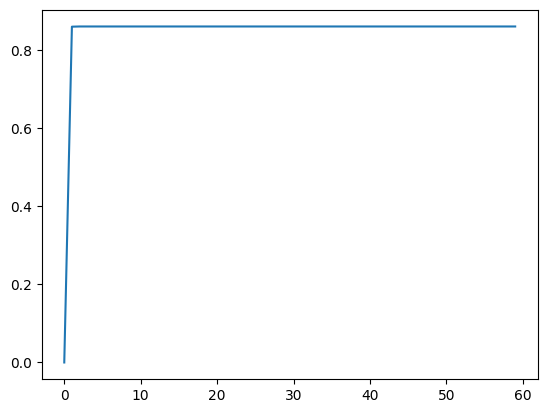

In [279]:
plt.plot(debug_opt.flatten_exps())

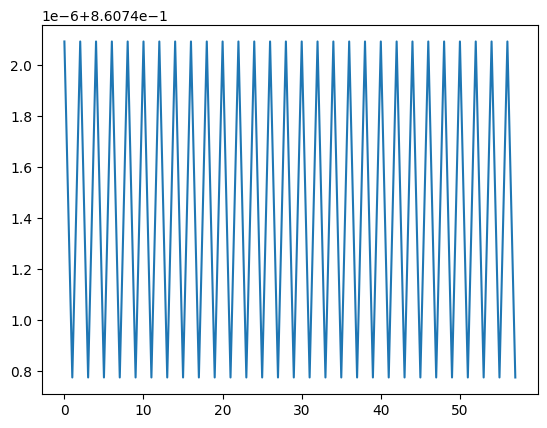

In [280]:
plt.plot(debug_opt.flatten_exps()[2:])

In [282]:
debug_opt.flatten_exps()[2:]

[0.8607420908523915,
 0.8607407754736195,
 0.8607420908523847,
 0.8607407754736195,
 0.8607420908523673,
 0.8607407754736189,
 0.860742090852411,
 0.8607407754736196,
 0.8607420908523816,
 0.8607407754736192,
 0.8607420908523854,
 0.860740775473619,
 0.8607420908523788,
 0.8607407754736194,
 0.8607420908523634,
 0.8607407754736196,
 0.8607420908523902,
 0.8607407754736193,
 0.8607420908523964,
 0.8607407754736203,
 0.8607420908524049,
 0.8607407754736194,
 0.8607420908524104,
 0.8607407754736195,
 0.8607420908523705,
 0.8607407754736194,
 0.8607420908523707,
 0.8607407754736198,
 0.860742090852389,
 0.8607407754736203,
 0.8607420908523933,
 0.8607407754736193,
 0.860742090852391,
 0.8607407754736185,
 0.8607420908523956,
 0.86074077547362,
 0.8607420908523635,
 0.8607407754736196,
 0.860742090852378,
 0.8607407754736196,
 0.860742090852368,
 0.8607407754736187,
 0.8607420908523759,
 0.8607407754736202,
 0.86074209085239,
 0.8607407754736196,
 0.8607420908523663,
 0.8607407754736203,
 0

That's it!

# Conclusion
Need to increase virtual bond dimension.